In [1]:
import pennylane as qml
import pennylane.numpy as np
import jax.numpy as jnp
from scipy.special import legendre
import jax
import optax

from time import time
import pickle

import matplotlib.pyplot as plt


import os, sys, argparse

parent = os.path.abspath('../src')
sys.path.insert(1, parent)

from perceptron import NativePerceptron

# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")


In [2]:
class Perceptron():

    # dev1 = qml.device("default.qubit", wires=4)


    # def __init__(self, n_qubits, control_fields, loss_hamiltonian_list, time=1.0, n_basis = 5, basis='Fourier', initial_psi=None, js=None, vs=None, constrained=False):

    def __init__(self, n_qubits, time=1.0, n_basis = 5, basis='Fourier', initial_psi=None, js=None, vs=None, constrained=False):

        self.n_qubits = n_qubits
        # self.native_hamiltonian_graph = native_hamiltonian_graph
        # self.control_fields=control_fields
        # self.loss_hamiltonian_list=loss_hamiltonian_list
        self.time=time
        self.n_basis=n_basis
        self.basis=basis
        # self.method=method
        self.constrained = constrained
        
        # if js is None: self.js = np.random.rand(len(self.native_hamiltonian_graph))
        if js is None: self.js = np.random.rand(n_qubits-1, requires_grad = True)
        else: self.js = js
        
        # if vs is None: self.vs =  np.random.rand([len(self.control_fields), n_basis])
        if vs is None: self.vs =  np.random.rand(2*n_qubits, n_basis, requires_grad = True)
        else: self.vs = vs
        
        if initial_psi is None:
            self.initial_psi = np.zeros(2**self.n_qubits)
            self.initial_psi[0] = 1.0
        else: self.initial_psi = initial_psi
        
        # self.sx = torch.tensor([[0j,1.],[1.,0j]])
        # self.sy = torch.tensor([[0.,-1j],[1j,0.]])
        # self.sz = torch.tensor([[1.,0j],[0,-1.]])
        # self.I2 = torch.tensor([[1.0, 0j],[0,1.]])
        

        self.perceptron_hamiltonian = self.get_system_hamiltonian()

    def get_hamiltonian(self, params):

        # building the native hamiltonian
        native_hamiltonian_graph = [qml.PauliZ(i) @ qml.PauliZ(self.n_qubits-1) for i in range((self.n_qubits-1))]
        native_hamiltonian = qml.Hamiltonian(params[:self.n_qubits-1], native_hamiltonian_graph)

        # building the control hamiltonian
        control_hamiltonian_operators = [qml.PauliY(i) for i in range(self.n_qubits)]
        control_hamiltonian_operators += [qml.PauliX(i) for i in range(self.n_qubits)]
        control_hamiltonian = qml.Hamiltonian(params[self.n_qubits-1:], control_hamiltonian_operators)

        return native_hamiltonian + control_hamiltonian

    def get_system_hamiltonian(self):

        # building the native hamiltonian
        self.native_hamiltonian_graph = [qml.PauliZ(i) @ qml.PauliZ(self.n_qubits-1) for i in range((self.n_qubits-1))]
        self.native_hamiltonian = qml.Hamiltonian(self.js, self.native_hamiltonian_graph)

        # building the control hamiltonian

        self.control_hamiltonian_operators = [qml.PauliY(i) for i in range(self.n_qubits)]
        self.control_hamiltonian_operators += [qml.PauliX(i) for i in range(self.n_qubits)]

        def system_hamiltonian(t):
            # for i in range(2*n_qubits):
            #     control_hamiltonian_coefficients.append(self.generate_p(i))

            control_hamiltonian_coefficients = [self.generate_p(i)(t) for i in range(2*n_qubits)]

            control_hamiltonian = qml.Hamiltonian(control_hamiltonian_coefficients, self.control_hamiltonian_operators)

            return control_hamiltonian + self.native_hamiltonian

        return system_hamiltonian



    def generate_p(self, i):
        """Generate the function p_i(t) for H_i
        Args:
            i: index of the H_i.
            coefficient of shape [nqubits, 2] 
        Returns:
            p: function p_i(t).
        """

        def p(t):
            if self.basis == 'Fourier':
                u = np.dot(self.vs[i,:],np.cos(2*np.pi*(t/self.time)*np.arange(self.n_basis)))
            elif self.basis == 'poly':
                u = np.dot(self.vs[i,:],(t/self.time)**np.arange(self.n_basis))
            # elif self.basis == 'Legendre':
            #     u = torch.dot(self.vs[i,:],lp(t/self.time, torch.arange(self.n_basis)))

            return u
        
        return p
        

    def setup_time_evolution_circuit(self, t, dt, trotter_number=1):

        times = np.arange(0, t, dt)

        for time in times:

            qml.ApproxTimeEvolution(self.perceptron_hamiltonian(time) , dt, trotter_number)
        

    def loss(self, t, dt, trotter_number, loss_hamiltonian):

        self.forward(t, dt, trotter_number)

        return qml.expval(loss_hamiltonian)




In [3]:

n_qubits = 4

dev1 = qml.device("default.qubit", wires=n_qubits)

perceptron = Perceptron(n_qubits)


perceptron_hamiltonian = perceptron.get_hamiltonian


perceptron_hamiltonian([np.random.uniform() for i in range(n_qubits*3 - 1)])



  (0.3848514445843555) [Y1]
+ (0.4933422761463815) [X2]
+ (0.582733092655832) [X0]
+ (0.7381856450642311) [Y0]
+ (0.79533702102278) [Y2]
+ (0.8643771265581542) [Y3]
+ (0.8852899135769564) [X1]
+ (0.9684973811950135) [X3]
+ (0.285459521031161) [Z2 Z3]
+ (0.894558538105331) [Z1 Z3]
+ (0.9866023861152542) [Z0 Z3]


In [4]:
time_evolution_steps = 10

params = np.array([np.random.uniform() for i in range((n_qubits*3 - 1)*time_evolution_steps)], requires_grad=True)


dev = qml.device("default.qubit", wires=n_qubits)
@qml.qnode(dev)
def circuit(params):

    padding = n_qubits*3 - 1

    # for i in range(n_qubits): # Making the initial CSS
    #     qml.Hadamard(wires=i)

    for jj in range(time_evolution_steps):

        H = perceptron.get_hamiltonian(params[padding*jj: padding*(jj+1)])

        qml.evolve(H, num_steps = 5)

        # qml.adjoint(qml.evolve(H, num_steps = 2))


    return qml.state()


In [5]:
circuit(params)

tensor([-0.05935781-0.15310362j,  0.27500037-0.09380616j,
        -0.01264819-0.33942096j,  0.07812628-0.04002943j,
        -0.24011975-0.03132301j,  0.20094608+0.08365903j,
         0.05161362-0.1783771j ,  0.2146001 -0.35139339j,
        -0.11216917+0.22537544j, -0.06477491+0.00750952j,
        -0.11276834-0.22243636j, -0.04925616+0.27232908j,
        -0.15076508+0.2498425j , -0.20032332+0.12599186j,
         0.03896467+0.16703943j, -0.271431  -0.0696185j ], requires_grad=True)

/Users/jorgegarciaponce/Research/Yelin/PerceptronLossLandscapes/.venv/lib/python3.11/site-packages/pennylane/drawer/mpldrawer.py:545: UserWarning: Glyph 120023 (\N{MATHEMATICAL BOLD SCRIPT CAPITAL H}) missing from current font.
  bbox = text_obj.get_window_extent(renderer)
/Users/jorgegarciaponce/Research/Yelin/PerceptronLossLandscapes/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 120023 (\N{MATHEMATICAL BOLD SCRIPT CAPITAL H}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


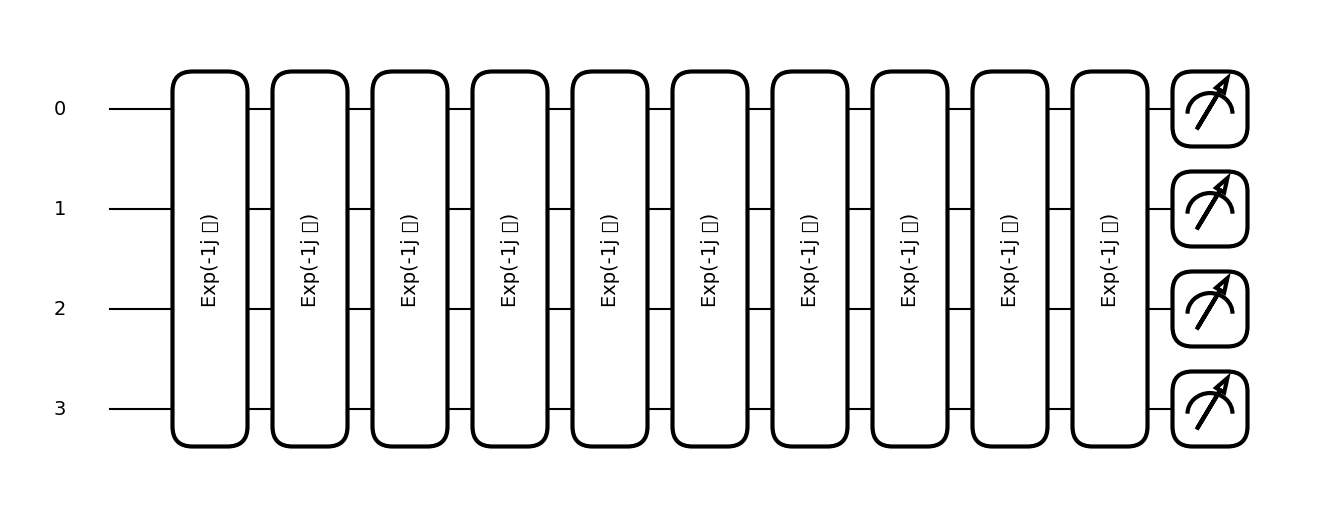

In [6]:
drawer = qml.draw(circuit)

fig, ax = qml.draw_mpl(circuit)(params)
plt.show()

In [7]:
natural_gradient = qml.metric_tensor(circuit, approx='block-diag')(params)

In [8]:
np.set_printoptions(suppress=True, precision=5, linewidth=170)
print(natural_gradient)

[[0.02986 0.      0.      ... 0.      0.      0.     ]
 [0.      0.05696 0.      ... 0.      0.      0.     ]
 [0.      0.      0.05614 ... 0.      0.      0.     ]
 ...
 [0.      0.      0.      ... 0.19314 0.      0.     ]
 [0.      0.      0.      ... 0.      0.13782 0.     ]
 [0.      0.      0.      ... 0.      0.      0.18265]]


In [3]:
# setting up the problem
perceptron_qubits = 4
pulse_basis = 5
ts = jnp.array([0.0, 1.0])

perceptron = NativePerceptron(perceptron_qubits, pulse_basis, basis='gaussian', pulse_width=0.5e-2)

H =  perceptron.H

H_obj, H_obj_spectrum = perceptron.get_1d_ising_hamiltonian(0.1)

e_ground_state_exact = H_obj_spectrum[0]

print(f'Ising Model Hamiltonian:\nH = {H_obj}')
print(f'Exact ground state energy: {e_ground_state_exact}')


Ising Model Hamiltonian:
H =   (0.1) [X0]
+ (0.1) [X1]
+ (0.1) [X2]
+ (0.1) [X3]
+ (1.0) [Z0 Z1]
+ (1.0) [Z1 Z2]
+ (1.0) [Z2 Z3]
Exact ground state energy: -3.015111523799075


In [5]:
param_vector = perceptron.get_random_parameter_vector(0)
param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)


In [12]:
H_t = H(param_list, 1)
H_t

(1*((PauliZ(wires=[0]) @ PauliZ(wires=[3])) + (PauliZ(wires=[1]) @ PauliZ(wires=[3])) + (PauliZ(wires=[2]) @ PauliZ(wires=[3])))) + ((((((((9.661408780874357e-241*(PauliX(wires=[0]))) + (9.776290482596198e-241*(PauliX(wires=[1])))) + (2.7817914021033507e-240*(PauliX(wires=[2])))) + (5.956959470702659e-241*(PauliX(wires=[3])))) + (2.4369594052545405e-240*(PauliY(wires=[0])))) + (1.8285720411527272e-240*(PauliY(wires=[1])))) + (3.142882720682321e-240*(PauliY(wires=[2])))) + (9.492594947682825e-241*(PauliY(wires=[3]))))

In [15]:
H.H_fixed()

1*((PauliZ(wires=[0]) @ PauliZ(wires=[3])) + (PauliZ(wires=[1]) @ PauliZ(wires=[3])) + (PauliZ(wires=[2]) @ PauliZ(wires=[3])))

In [14]:

# Check the type of H_t
print("Type of H_t:", type(H))

# Check if H_t is an instance of qml.Hamiltonian
if isinstance(H_t, qml.Hamiltonian):
    print("H_t is an instance of qml.Hamiltonian")
else:
    print("H_t is not an instance of qml.Hamiltonian")

Type of H_t: <class 'pennylane.pulse.parametrized_hamiltonian.ParametrizedHamiltonian'>
H_t is not an instance of qml.Hamiltonian


In [17]:
qml.ApproxTimeEvolution(H.H_fixed() , 0.1, 1)

ValueError: hamiltonian must be of type pennylane.Hamiltonian, got SProd

In [ ]:

    times = np.arange(0, t, dt)

    for time in times:

        qml.ApproxTimeEvolution(self.perceptron_hamiltonian(time) , dt, trotter_number)
    


In [3]:
dev = qml.device("default.qubit.jax", wires = perceptron_qubits)


@qml.qnode(dev, interface="jax")
def loss(param_vector):

    # hamitlonian_params = dictionary_to_hamiltonian_parameters(params_dict)

    param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

    qml.evolve(perceptron.H)(param_list, ts)

    return qml.expval(H_obj)

    
param_vector = perceptron.get_random_parameter_vector(0)
param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

loss(param_vector)

Array(0.57475118, dtype=float64)

In [10]:

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)
ops = [qml.evolve(perceptron.H)(param_list, ts)]
measurements = [qml.state()]
tape = qml.tape.QuantumTape(ops, measurements)

In [12]:
qml.metric_tensor(tape)

([],
 <function pennylane.transforms.metric_tensor.metric_tensor.<locals>.<lambda>(_)>)

In [5]:
loss

<QNode: wires=4, device='default.qubit.jax', interface='jax', diff_method='best'>

In [13]:
param_vector = perceptron.get_random_parameter_vector(0)


qml.metric_tensor(loss)(param_vector)

ValueError: Operation ParametrizedEvolution is not written in terms of a single parameter